In [1]:
# Packages imports
import numpy as np
import pandas as pd
from scipy import stats as stats
from statsmodels.stats import api as sms
from matplotlib import pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
%matplotlib inline

# Some plot styling preferences
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Remove users appearing multiple times as they can skew the results
session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1]

print(f'There are {multi_users.count()} users that appear multiple times in the dataset')
df = df[~ df.user_id.isin(multi_users.index)]

There are 3894 users that appear multiple times in the dataset


In [7]:
# Conversion rate on the old page is 
pop_mean = round(df[df.landing_page == 'old_page'].converted.mean(), 4)
f"{round(100 * df[df.landing_page == 'old_page'].converted.mean(), 4)}%"

'12.0173%'

In [8]:
# Current effect is known to be at 13%. Expecting the change to increase the conversion rate to 15%
# Known population mean (13%). So Z-test
effect_size = sms.proportion_effectsize(pop_mean, 0.15)

# Calculate the sample size for the test.
# Assume 80% power with significance level of .05
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power = 0.8, 
    alpha = 0.05, 
    ratio = 1 # (Control N / Experiment N)
)

required_n = ceil(required_n)

print("Sample Size:", required_n)

Sample Size: 2060


In [9]:
# Sample n_samples from each group - control and treatment groups
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state = 22)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state = 22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
4115,769020,2017-01-17 18:44:49.619558,treatment,new_page,0
4116,679472,2017-01-24 00:38:26.279943,treatment,new_page,0
4117,849658,2017-01-08 23:38:19.530145,treatment,new_page,0
4118,919921,2017-01-07 07:00:09.427271,treatment,new_page,0


In [10]:
# Capture the mean, standard deviation and standard_error of success rates in each group
conversion_rates = ab_test.groupby('group')['converted'].agg(["mean", "std", stats.sem])

conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.round(3)

,conversion_rate,std_deviation,std_error
group,,,
control,0.122,0.327,0.007
treatment,0.117,0.321,0.007


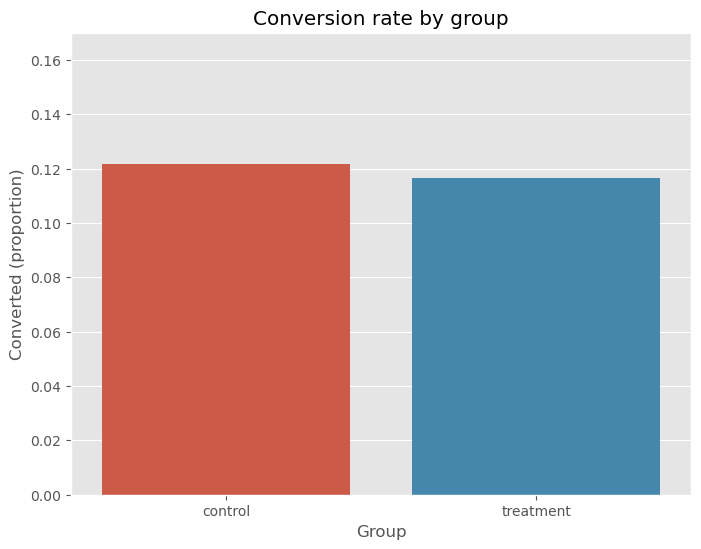

In [11]:
plt.figure(figsize = (8, 6))

sns.barplot(x = ab_test['group'], y = ab_test['converted'], errorbar = ('ci', False))

plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

In [12]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs = nobs, alpha = 0.05)

print(f'z statistic: {z_stat : .2f}')
print(f'p-value: {pval : .3f}')
print(f'ci 95% for control group: [{lower_con : .3f}, {upper_con : .3f}]')
print(f'ci 95% for treatment group: [{lower_treat : .3f}, {upper_treat : .3f}]')

z statistic:  0.53
p-value:  0.597
ci 95% for control group: [ 0.108,  0.136]
ci 95% for treatment group: [ 0.103,  0.130]


<b>Since our p-value=0.597 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one</b>